# Classifiez automatiquement des biens de consommation

## Phase 2 : Analyse des données visuelles

Pour cette étape, on va utiliser ORB pour classifier les données visuelles, on va voir si on obtient un score aussi bien que celui pour l'analyse des données visuelles

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import math
import warnings
import cv2

from time import time

from sklearn.cluster import KMeans, MiniBatchKMeans
from scipy.ndimage import gaussian_filter
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestNeighbors


from sklearn.ensemble import RandomForestClassifier

    
sns.set()
%matplotlib inline

warnings.filterwarnings('ignore')

On récupère nos données précédemment sauvegardées

In [2]:
data  = pd.read_feather('data.ft')

In [3]:
data.head()

,image,description,main category
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing


Testons l'affichage d'une image en utilisant open cv

In [4]:
img_path = 'Flipkart/Images/3f9c4d0e8c3bca9c870e41f5098f90d6.jpg'
img = cv2.imread(img_path)
def show_rgb_img(img):
    """Convenience function to display a typical color image"""
    return plt.imshow(cv2.cvtColor(img, cv2.CV_32S))

def to_gray(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray


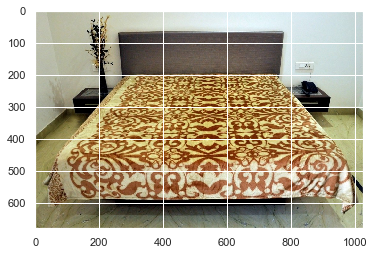

In [5]:
show_rgb_img(img)

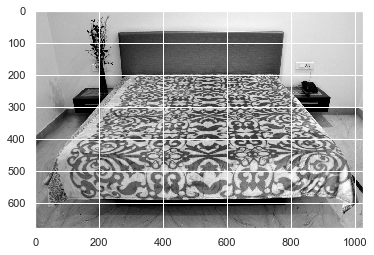

In [6]:
# on va faire une transformation basique en la transformant en gray
gray = to_gray(img)
plt.imshow(gray, cmap='gray');

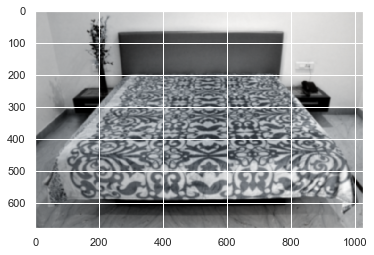

In [7]:
# avec un gausian filter
img = gaussian_filter(img, sigma=2)
plt.imshow(img);

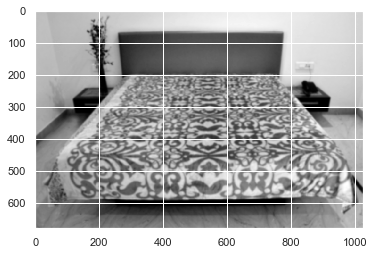

In [8]:
# avec un gausian filter
gray = gaussian_filter(gray, sigma=2)
plt.imshow(gray, cmap='gray');

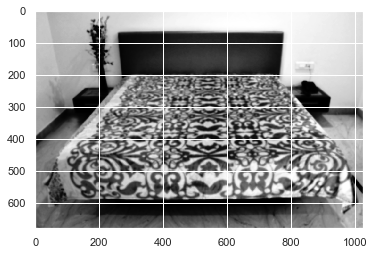

In [9]:
# en égalisant l'histogramme
img = cv2.equalizeHist(gray)
plt.imshow(img, cmap='gray')

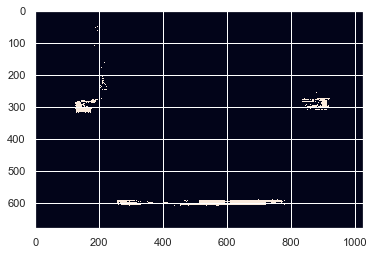

In [10]:
img = cv2.imread(img_path)
backSub = cv2.createBackgroundSubtractorMOG2()
img = backSub.apply(img)
plt.imshow(img)

In [11]:
def gen_orb_features(gray_img):
    orb = cv2.ORB_create()
    # kp is the keypoints
    #
    # desc is the ORB descriptors
    kp, desc = orb.detectAndCompute(gray_img, None)
    return kp, desc

# pour afficher les features sift
def show_orb_features(gray_img, color_img):
    orb = cv2.ORB_create()
    kp = orb.detect(gray_img,None)
    plt.figure(figsize = (10,10))
    return plt.imshow(cv2.drawKeypoints(gray_img, kp, color_img.copy()))

In [12]:
# generate ORB keypoints and descriptors
img_kp, img_desc = gen_orb_features(gray)

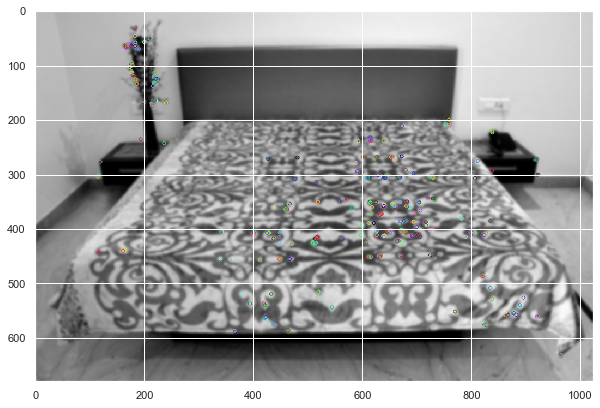

In [13]:
# Regardons ce que donnent les features sift
show_orb_features(gray, img);

In [14]:
# on regarde aussi les key points de l'image 
def explain_keypoint(kp):
    print('angle\n', kp.angle)
    print('\nclass_id\n', kp.class_id)
    print('\noctave (image scale where feature is strongest)\n', kp.octave)
    print('\npt (x,y)\n', kp.pt)
    print('\nresponse\n', kp.response)
    print('\nsize\n', kp.size)

explain_keypoint(img_kp[0])

angle
 173.7147216796875

class_id
 -1

octave (image scale where feature is strongest)
 0

pt (x,y)
 (200.0, 168.0)

response
 5.8567497035255656e-05

size
 31.0


### Extraction des descripteurs en utilisant ORB

In [15]:
# Méthode utilitaire pour extraire les key points et les descripteurs avec un des algos connus
def features(image, extractor):
    keypoints, descriptors = extractor.detectAndCompute(image, None)
    return keypoints, descriptors

# Méthode pur constuire un histogram de bag of features à partir d'un algo de clusetring et de descripteurs
def build_histogram(descriptor_list, cluster_alg):
    histogram = np.zeros(len(cluster_alg.cluster_centers_))
    cluster_result = cluster_alg.predict(descriptor_list)
    size = len(cluster_result)
    for i in cluster_result:
        histogram[i] += 1.0 / size
    return histogram


# Methode pour processer l'image
def process_image(img, sigma=5):
    img = to_gray(img)
        #flou gaussien
    img = gaussian_filter(img, sigma=sigma)
        #égalisation
    img = cv2.equalizeHist(img)
        # resizing
    img = image_resize(img, width=224, inter=cv2.INTER_AREA)
    return img


# on resize l'image en maintenant le même rapport de dimensions
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

On regarde ce que donne l'image quand on la process

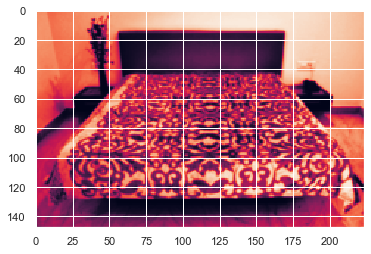

In [16]:
img = cv2.imread(img_path)
processed_img= process_image(img, sigma=2)
plt.imshow(processed_img)

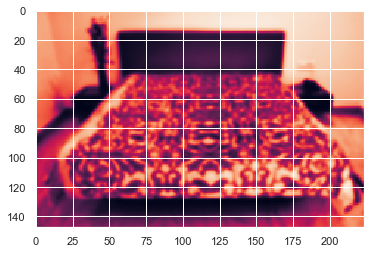

In [17]:
# si on change le flou gaussien 
processed_img= process_image(img, sigma=5)
plt.imshow(processed_img)

On va d'abord générer les descripteurs pour chacune de nos image, et les mettre dans notre dataframe, on va générer à la fois les descripteurs pour les images processées, et non processées, pour voir lequel donne de meilleurs résultats

In [18]:
orb = cv2.ORB_create()

def set_descriptors(row, process):
    img_name = row['image']
    img_path = 'Flipkart/Images/'+ img_name
    img = cv2.imread(img_path)
    if process:
        img = process_image(img, sigma=2)
    kps, descs = features(img, orb)
    return descs

t0 = time()
data['descriptors'] = data.apply(lambda row : set_descriptors(row, False), axis=1)
print("done in %0.3fs" % (time() - t0))

done in 120.658s


In [19]:
t0 = time()
data['descriptors_processed'] = data.apply(lambda row : set_descriptors(row, True), axis=1)
print("done in %0.3fs" % (time() - t0))

done in 122.759s


In [20]:
data.dropna(how='any', inplace=True)

In [21]:
# finaement on split nos descripteurs entre jeu de test et jeu de training
X_train, X_test, y_train, y_test = train_test_split(data[['descriptors', 'descriptors_processed']], data['main category'], test_size=0.20, random_state=42)

### Genération de l'histogramme: Bag of features

On commence par aggréger tous les descripteurs dans un seul vecteur, et on va utiliser un Kmeans sur un nombre de clusters, et à la fin, on pourra générer un histogramme par image basé sur le résultat du clustering du Kmeans

In [22]:
# D'abord les descripteurs des images 'non processées'
descriptors_list = []
for descs in X_train['descriptors']:
    descriptors_list.extend(descs)

In [23]:
# puis les descripteurs des images 'processées'
descriptors_processed_list = []
for descs in X_train['descriptors_processed']:
    descriptors_processed_list.extend(descs)

In [24]:
data['main category'].nunique()

7

In [25]:
len(descriptors_list)

402077

In [26]:
# A cause du temps énorme qu'utilise le Kmeans pour toute ces données, on va utiliser un MiniBatchKMeans qui est beaucoup plus rapide avec une perte de précision moindre
t0 = time()

kmeans = MiniBatchKMeans(n_clusters = 1000, max_iter=500)
kmeans.fit(descriptors_list)
print('done in %0.3fs' % (time() - t0))

done in 139.975s


In [27]:
t0 = time()
kmeans_processed = MiniBatchKMeans(n_clusters = 1000, max_iter=500)
kmeans_processed.fit(descriptors_processed_list)
print('done in %0.3fs' % (time() - t0))

done in 92.129s


Donc par descriptor on a un cluster associé, chaque image a sa liste de clusters associés, qu'on va stocker dans la variabe histogram ou histogram_processed

In [28]:
def set_histogram(row, descriptors_name, kmeans):
    descriptors = row[descriptors_name]
    return build_histogram(descriptors, kmeans)

data['histogram'] = data.apply(lambda row : set_histogram(row, 'descriptors', kmeans), axis=1)
data['histogram_processed'] = data.apply(lambda row : set_histogram(row, 'descriptors_processed', kmeans_processed), axis=1)

X_train, X_test, y_train, y_test = train_test_split(data[['descriptors', 'descriptors_processed', 'histogram', 'histogram_processed']], data['main category'], test_size=0.20, random_state=42)


In [29]:
X_train.head()

,descriptors,descriptors_processed,histogram,histogram_processed
256,"[[2, 161, 98, 134, 84, 144, 168, 101, 40, 192,...","[[30, 171, 150, 152, 211, 176, 188, 239, 191, ...","[0.0, 0.0, 0.0, 0.0, 0.002, 0.0, 0.002, 0.0, 0...","[0.0, 0.002242152466367713, 0.0, 0.0, 0.006726..."
352,"[[2, 144, 54, 152, 75, 205, 185, 64, 175, 93, ...","[[10, 151, 50, 169, 55, 178, 186, 99, 61, 13, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0022779043280...","[0.0, 0.01834862385321101, 0.0, 0.0, 0.0, 0.0,..."
60,"[[137, 105, 150, 95, 141, 183, 105, 92, 247, 2...","[[254, 41, 254, 224, 203, 214, 88, 71, 173, 16...","[0.0, 0.0, 0.0, 0.002, 0.0, 0.002, 0.0, 0.0, 0...","[0.0, 0.0, 0.0, 0.002183406113537118, 0.0, 0.0..."
345,"[[158, 88, 231, 186, 107, 64, 189, 220, 140, 8...","[[148, 237, 198, 159, 156, 171, 166, 239, 62, ...","[0.0, 0.0, 0.0, 0.0, 0.004132231404958678, 0.0...","[0.0, 0.019083969465648856, 0.0, 0.0, 0.0, 0.0..."
382,"[[2, 136, 76, 95, 74, 129, 171, 162, 182, 48, ...","[[11, 151, 99, 207, 244, 118, 239, 255, 93, 75...","[0.0, 0.0, 0.002403846153846154, 0.0, 0.0, 0.0...","[0.0, 0.0, 0.0029154518950437317, 0.0, 0.00583..."


### Classification des données

On va tester de classifier les données avec un random forest on rappelle que pour les données textuelles le score de training était de 0.94

In [32]:
# On utilise une fonction qui va faire l'estimation et imprimer les  différents résultats
def estimate(estimator, parameters, X_train, X_test, y_train, y_test):
    grid_search = GridSearchCV(estimator, parameters, n_jobs=-1, verbose=-1, cv=5)

    print("Performing grid search...")
    print("parameters:")
    print(parameters)
    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best cross validation score: %0.3f" % grid_search.best_score_)
    print("Testing set score: %0.3f" % grid_search.best_estimator_.score(X_test, y_test))
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
    return grid_search.best_estimator_

In [33]:
# on utilise d'abord l'algo sur les images non processées
reg = RandomForestClassifier(random_state=42)
param_grid = {'bootstrap': [True],
              'max_depth': range(6,10),
              'min_samples_leaf': range(2,5),
              'min_samples_split': range(2,5),
              'n_estimators': [500]}
rf_estimator = estimate(reg, param_grid, 
                        list(X_train['histogram']), list(X_test['histogram']), 
                        y_train, y_test)

Performing grid search...
parameters:
{'bootstrap': [True], 'max_depth': range(6, 10), 'min_samples_leaf': range(2, 5), 'min_samples_split': range(2, 5), 'n_estimators': [500]}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.6min finished


done in 101.348s

Best cross validation score: 0.389
Testing set score: 0.371
Best parameters set:
	bootstrap: True
	max_depth: 9
	min_samples_leaf: 3
	min_samples_split: 2
	n_estimators: 500


In [34]:
# puis sur les images processées
reg = RandomForestClassifier(random_state=42)
param_grid = {'bootstrap': [True],
              'max_depth': range(6, 10),
              'min_samples_leaf': range(2,5),
              'min_samples_split': range(2,5),
              'n_estimators': [500]}
rf_estimator_p = estimate(reg, param_grid, 
                          list(X_train['histogram_processed']), list(X_test['histogram_processed']),
                          y_train, y_test)

Performing grid search...
parameters:
{'bootstrap': [True], 'max_depth': range(6, 10), 'min_samples_leaf': range(2, 5), 'min_samples_split': range(2, 5), 'n_estimators': [500]}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.1min finished


done in 132.711s

Best cross validation score: 0.385
Testing set score: 0.367
Best parameters set:
	bootstrap: True
	max_depth: 9
	min_samples_leaf: 4
	min_samples_split: 2
	n_estimators: 500


In [38]:
# pour finir on teste juste les nearest neighbors par rapport à une image
neighbor = NearestNeighbors(n_neighbors = 10, p=2)
neighbor.fit(list(X_train['histogram_processed']))

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                 radius=1.0)

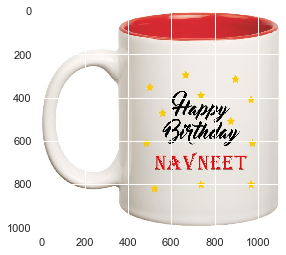

In [41]:
img_name = '0c70a580d96e50966130e2885d8c3505.jpg'
img_path = 'Flipkart/Images/'+ img_name
img = cv2.imread(img_path)
img = process_image(img, sigma=2)
kps, descs = features(img, orb)

histogram = build_histogram(descs, kmeans_processed)
dist, result = neighbor.kneighbors([histogram])
show_rgb_img(cv2.imread(img_path))

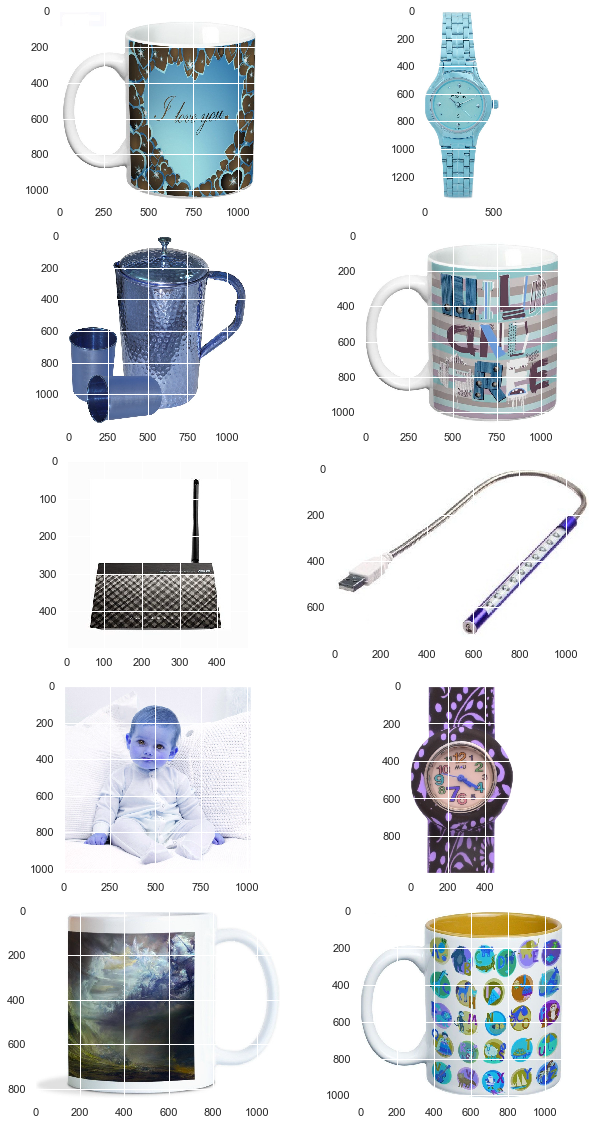

In [42]:
images = list(data['image'])
fig=plt.figure(figsize=(10, 20))
columns = 2
rows = 5
j = 1
for i in result[0]:
    fig.add_subplot(rows, columns, j)
    plt.imshow(cv2.imread('Flipkart/Images/' + images[i]))
    j = j+1
plt.show()

Quelques images matchent, mais d'autres ne matchent pas du tout, le set de données ne contient pas assez de représentations par image pour avoir des résultats approbants

On va essayer de voir si on peut voir des clusters s'afficher avec un afficage 2D en UMAP

In [45]:
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

import umap 

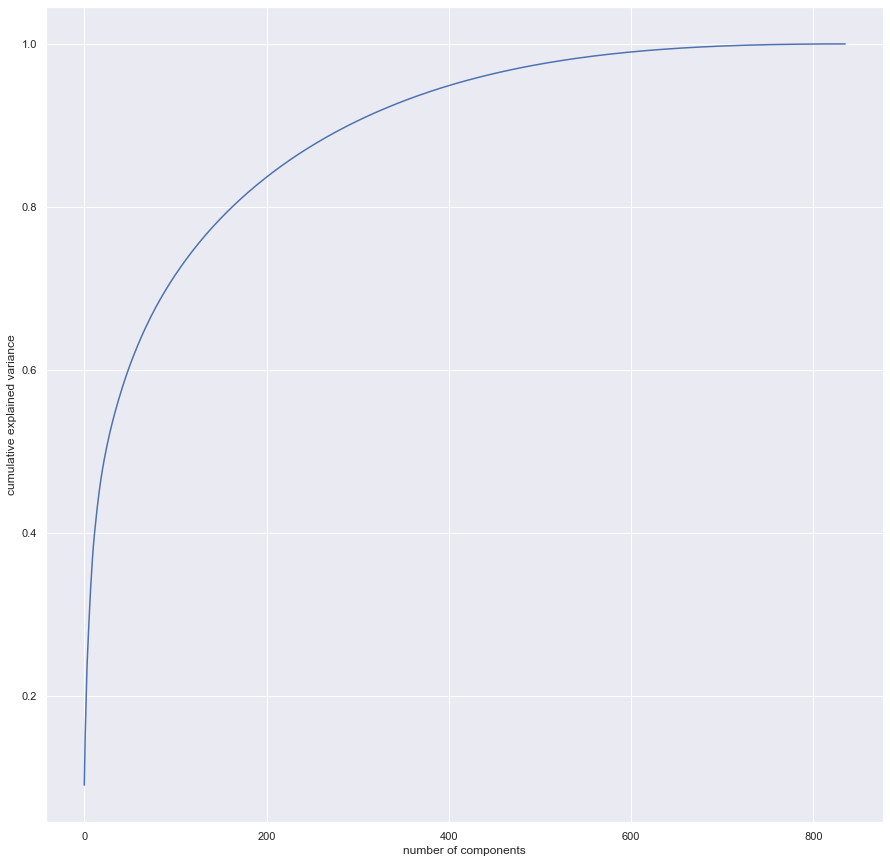

In [46]:
# On va réduire la dimension à l'aide d'une PCA
pca = PCA().fit(list(X_train['histogram_processed']))
plt.figure(figsize=(15,15))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [47]:
# Avec 400 colonnes on explique déjà plus que 90% de la variance
n_columns = 400
pca = PCA(n_columns).fit(list(X_train['histogram_processed']))
print('Variance expliquée est de {}'.format(pca.explained_variance_ratio_.sum()))

Variance expliquée est de 0.9475361313071023


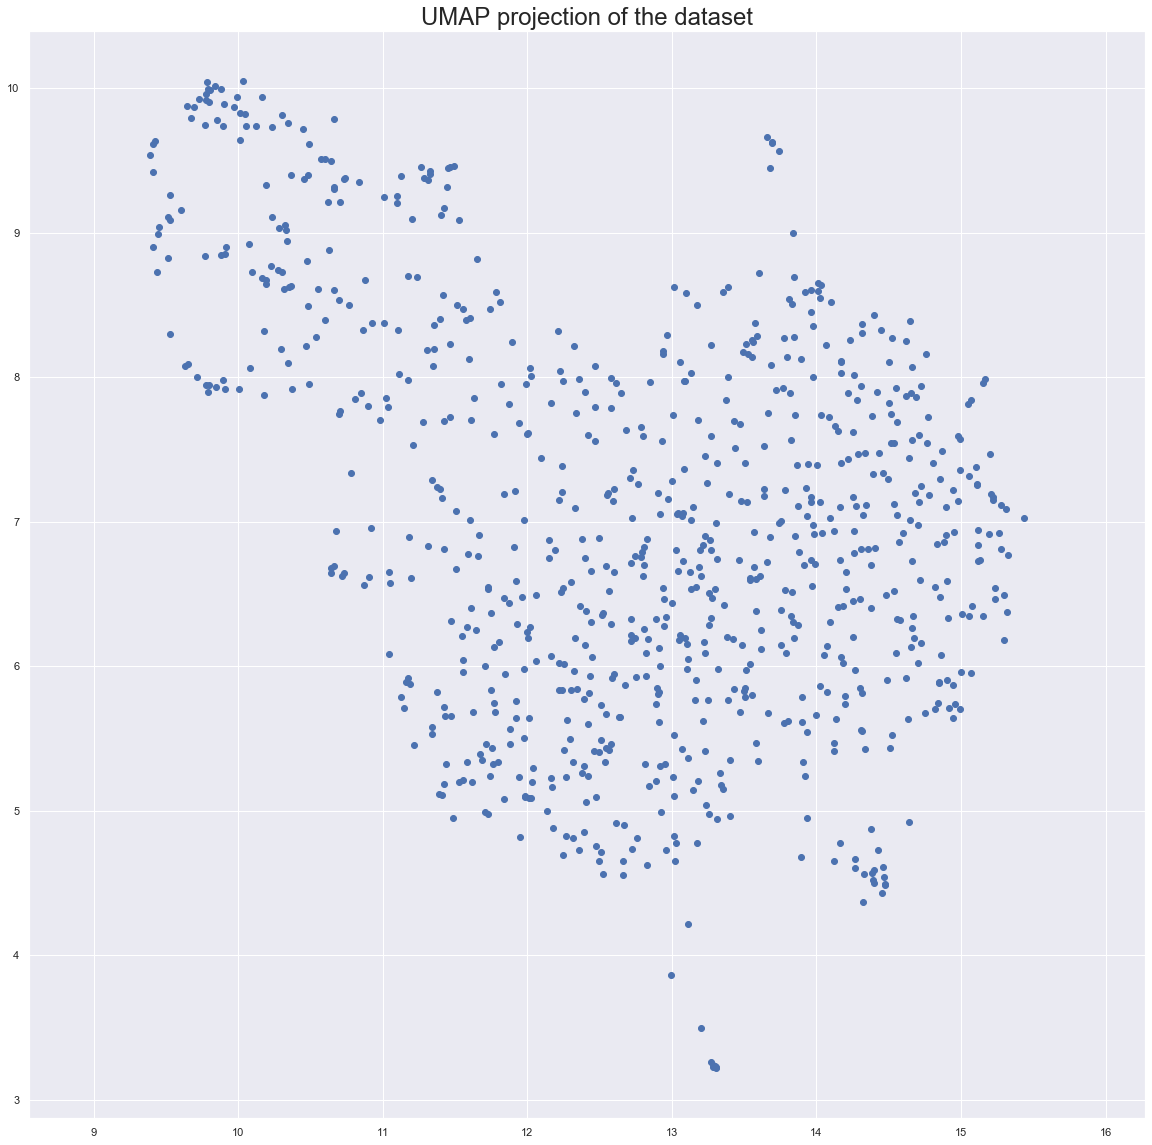

In [48]:
# on va finalement utiliser UMAP pour visualiser les différents clusters
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(list(X_train['histogram_processed']))[:,:n_columns]
plt.figure(figsize=(20,20))
plt.scatter(embedding[:, 0], embedding[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the dataset', fontsize=24);
plt.show()

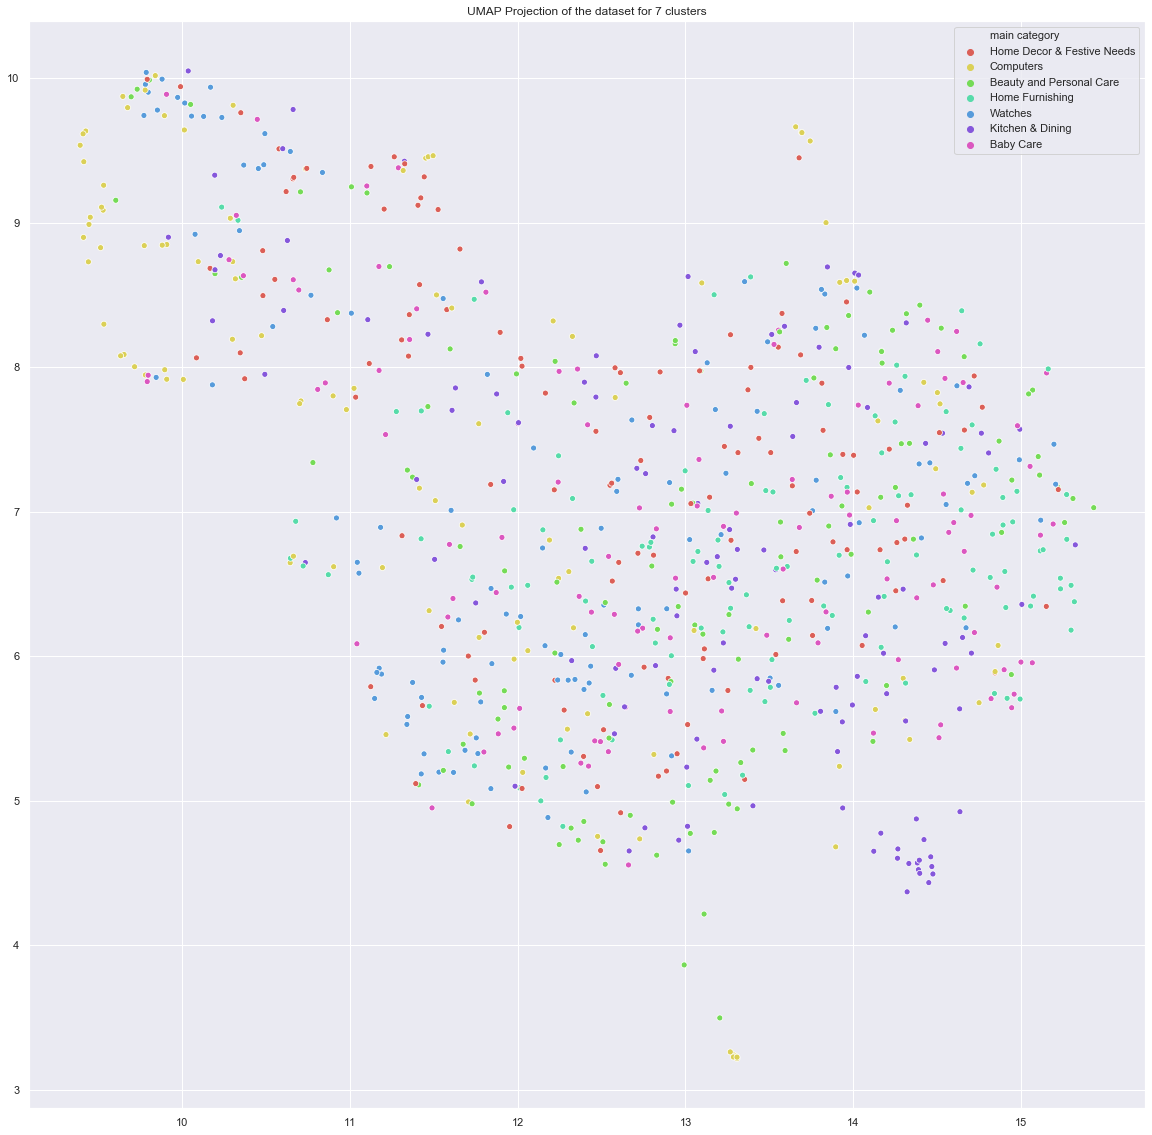

In [49]:
# On voit bien qu'on voit pas de clusters se dégager, essayons de voir on les colorant suivant nos catégories
plt.figure(figsize=(20,20))
plt.title('UMAP Projection of the dataset for 7 clusters')
sns.scatterplot(embedding[:,0], 
                embedding[:,1],
                hue=y_train,
                legend='full',
                palette=sns.color_palette('hls',7))

l'analyse sur les données visuelles s'avère peu fructueuse pour l'instant, on se dit que c'est à cause du manque d'image, c'est pour quoi dans le prochain notebook on va utiliser du transfer learning sur un réseau de neurones pré entrainé : ResNet50